# Task A: Short Dialogue2Note

Train shape: (1201, 4)
Validation shape: (100, 4)
Test shape: (200, 4)
Train columns: Index(['ID', 'section_header', 'section_text', 'dialogue'], dtype='object')


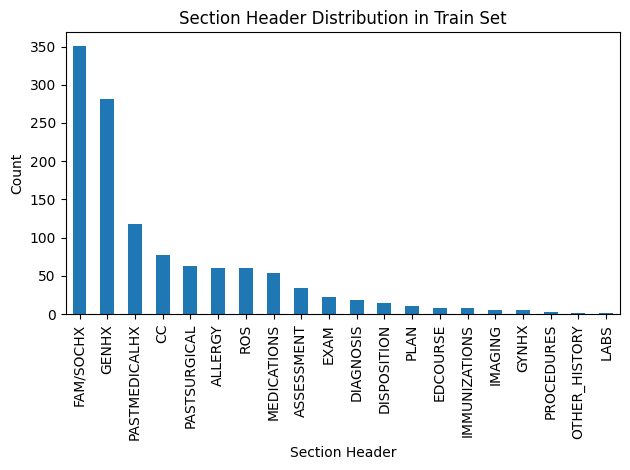

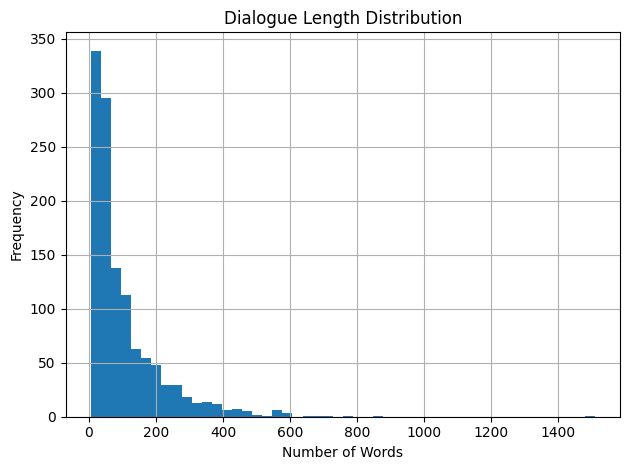

Map:   0%|          | 0/1201 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/var/folders/xk/jnrp42td7w1dgf4dpccfj6y00000gn/T/ipykernel_43466/3027191023.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.957200,0.812413
2,0.798600,0.744823
3,0.657100,0.734552
4,0.676500,0.724679
5,0.610100,0.726566


/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/ra

Predictions saved as 'MEDIQA_TaskA_Test_Predictions.csv'.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Load datasets
train_df = pd.read_csv('dataset/A/MTS-Dialog-TrainingSet.csv')
test_df = pd.read_csv('dataset/A/MTS-Dialog-TestSet-1-MEDIQA-Chat-2023.csv')
val_df = pd.read_csv('dataset/A/MTS-Dialog-ValidationSet.csv')

# EDA
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("Train columns:", train_df.columns)

# Plotting distribution of section headers
plt.figure()
train_df['section_header'].value_counts().plot(kind='bar', title='Section Header Distribution in Train Set')
plt.xlabel('Section Header')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Check conversation length distribution
train_df['dialogue_length'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
plt.figure()
train_df['dialogue_length'].hist(bins=50)
plt.title('Dialogue Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Preprocessing for summarization (Task A)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

max_input_length = 512
max_target_length = 128

def preprocess_data(examples):
    inputs = examples['dialogue']
    targets = [header + ': ' + text for header, text in zip(examples['section_header'], examples['section_text'])]
    
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


train_dataset = Dataset.from_pandas(train_df[['dialogue', 'section_header', 'section_text']])
val_dataset = Dataset.from_pandas(val_df[['dialogue', 'section_header', 'section_text']])

tokenized_train = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_data, batched=True, remove_columns=val_dataset.column_names)

training_args = TrainingArguments(
    output_dir="./mediqa_taskA_bart",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

trainer.train()

model = model.to("cpu")

gen_outputs = []
for dialogue in test_df['dialogue']:
    inputs = tokenizer(dialogue, return_tensors='pt', truncation=True, max_length=max_input_length, padding='max_length')
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=max_target_length,
            num_beams=4,
            early_stopping=True
        )
    gen_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    gen_outputs.append(gen_text)

test_df['generated_section_summary'] = gen_outputs
test_df.to_csv('output/MEDIQA_TaskA_Test_Predictions.csv', index=False)

print("Predictions saved as 'MEDIQA_TaskA_Test_Predictions.csv'.")

In [ ]:
import pandas as pd
import evaluate

pred_df = pd.read_csv('output/MEDIQA_TaskA_Test_Predictions.csv')

gt_df = pd.read_csv('dataset/A/MTS-Dialog-TestSet-1-MEDIQA-Chat-2023.csv')

assert len(pred_df) == len(gt_df), "Dimensions do not correspond."

predictions = pred_df['generated_section_summary'].astype(str).tolist()
references = (gt_df['section_header'].astype(str) + ': ' + gt_df['section_text'].astype(str)).tolist()

rouge = evaluate.load("rouge")

scores = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

for key, value in scores.items():
    print(f"{key}: {value:.4f}")

analysis_df = pd.DataFrame({
    "Dialogue": gt_df['dialogue'],
    "Ground Truth": references,
    "Prediction": predictions
})

analysis_df.to_csv('output/MEDIQA_TaskA_Test_Comparison_Top20.csv', index=False)

print("Top 20 examples saved in 'output/MEDIQA_TaskA_Test_Comparison_Top20.csv'.")


rouge1: 0.4020
rouge2: 0.2107
rougeL: 0.3524
rougeLsum: 0.3534
Top 20 examples saved in 'output/MEDIQA_TaskA_Test_Comparison_Top20.csv'.


In [15]:
# Extract predicted headers
predicted_headers = [pred.split(":")[0].strip().lower() for pred in predictions]
# Extract true headers
true_headers = gt_df['section_header'].str.strip().str.lower().tolist()

correct = sum([p == t for p, t in zip(predicted_headers, true_headers)])
accuracy = correct / len(true_headers)

print(f"\nSection Header Classification Accuracy: {accuracy*100:.2f}% ({correct}/{len(true_headers)}) corect")

errors = [
    {"Dialogue": d, "True Header": t, "Predicted Header": p, "Prediction": full_pred}
    for d, t, p, full_pred in zip(gt_df['dialogue'], true_headers, predicted_headers, predictions)
    if p != t
]

errors_df = pd.DataFrame(errors)
errors_df.to_csv('output/MEDIQA_TaskA_Header_Classification_Errors.csv', index=False)

print("Classification errors saved in 'output/MEDIQA_TaskA_Header_Classification_Errors.csv'.")


Section Header Classification Accuracy: 65.00% (130/200) corect
Classification errors saved in 'output/MEDIQA_TaskA_Header_Classification_Errors.csv'.
